<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from datetime import datetime as dt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
PATH_TO_DATA = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 
                                            '.', 'hw06', 'capstone_user_identification'))

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as site_freq_pkl:
        site_freq = pickle.load(site_freq_pkl)
    
    files = glob(os.path.join(path_to_csv_files, 'user*'))
    users = [pd.read_csv(file, parse_dates=['timestamp']) for file in files]
    user_ids = [int(file[-8:-4]) for file in files]
    extend_times = session_length // window_size + min(session_length % window_size, 1)
    
    get_site_idx = lambda site: site_freq[site][0]
    get_span = lambda row: (np.max(row) - np.min(row)).astype('timedelta64[s]').astype('int')
    get_unique = lambda row: len(list(filter(lambda x: x != 0, np.unique(row))))
    get_hour = lambda row: dt.utcfromtimestamp(np.min(row).astype('datetime64[s]').astype('int')).hour
    get_day = lambda row: dt.utcfromtimestamp(np.min(row).astype('datetime64[s]').astype('int')).weekday()
    
    def user_to_session(user, user_id):
        zeros_count = (window_size - user.shape[0] % window_size) % window_size
        
        sites = user['site'].map(get_site_idx).values
        sites = np.hstack([sites, np.zeros(zeros_count, dtype='int32')])
        sites = sites.reshape(-1, window_size)
        extend_sites = lambda i: np.vstack([sites[i:], np.zeros((min(i, sites.shape[0]), sites.shape[1]), dtype='int32')])
        sites = np.hstack(map(extend_sites, range(extend_times)))[:, :session_length]
        
        ts = user['timestamp'].values
        ts = np.hstack([ts, np.full(zeros_count, np.max(ts))])
        ts = ts.reshape(-1, window_size)
        extend_ts = lambda i: np.vstack([ts[i:], np.full((min(i, ts.shape[0]), ts.shape[1]), np.max(ts))])
        ts = np.hstack(map(extend_ts, range(extend_times)))[:, :session_length]
        
        diffs = np.diff(ts).astype('timedelta64[s]').astype('int')
        spans = np.apply_along_axis(get_span, 1, ts).reshape(-1, 1)
        uniques = np.apply_along_axis(get_unique, 1, sites).reshape(-1, 1)
        hours = np.apply_along_axis(get_hour, 1, ts).reshape(-1, 1)
        days = np.apply_along_axis(get_day, 1, ts).reshape(-1, 1)
        user_id = np.full((sites.shape[0], 1), user_id)
        
        return np.hstack([sites, diffs, spans, uniques, hours, days, user_id])
    
    sessions = np.vstack(map(user_to_session, users, user_ids))
    return pd.DataFrame(data=sessions, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      7      2      1      8      5      9      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2.12 s, sys: 43.9 ms, total: 2.17 s
Wall time: 2.18 s


In [7]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 21.8 s, sys: 361 ms, total: 22.2 s
Wall time: 22.8 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[feature_names[-5:-1]]
new_features_150users = train_data_150users[feature_names[-5:-1]]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [15]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [16]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [9]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)
usernames = list(id_name_dict.values())

In [55]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [73]:
ax = train_data_10users['session_timespan'].hist(bins=np.arange(0, 200+5, 5),
    grid=False, color='darkviolet', figsize=(12, 4));
ax.set_xlabel('длина сессии, с');
ax.set_ylabel('количество значений');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

In [74]:
session_length = 10
ax = train_data_10users['#unique_sites'].hist(bins=np.arange(1, session_length+2), 
    grid=False, color='aqua');
ax.set_xlabel('число уникальных сайтов в сессии');
ax.set_ylabel('количество значений');
ax.set_xticks(np.arange(1, session_length+1));

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

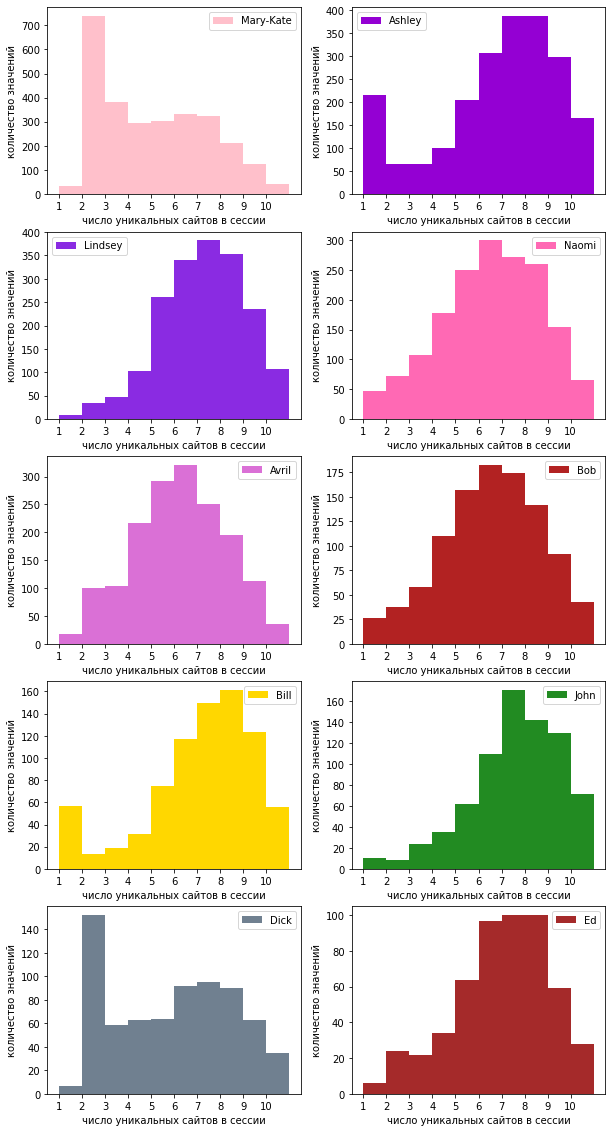

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for idx, ax in enumerate(axes.ravel()):
    data = train_data_10users[train_data_10users['target'] == usernames[idx]]['#unique_sites']
    ax.hist(data, bins=np.arange(1, session_length+2), color=color_dic[usernames[idx]])
    ax.set_xlabel('число уникальных сайтов в сессии')
    ax.set_ylabel('количество значений')
    ax.legend([usernames[idx]])
    ax.set_xticks(np.arange(1, session_length+1))

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

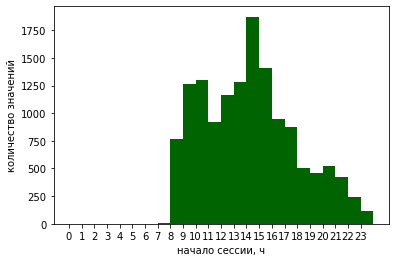

In [75]:
hours = 24
ax = train_data_10users['start_hour'].hist(bins=np.arange(hours+1),
    grid=False, color='darkgreen');
ax.set_xlabel('начало сессии, ч');
ax.set_ylabel('количество значений');
ax.set_xticks(np.arange(hours));

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

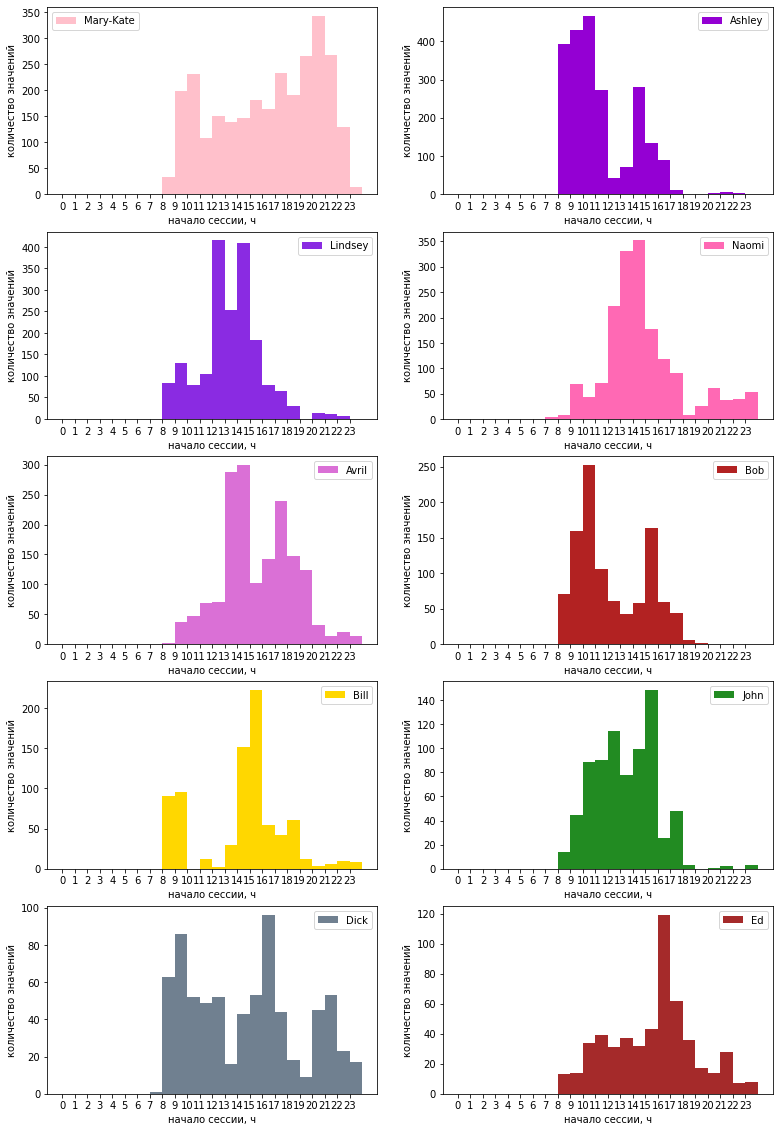

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 20))

for idx, ax in enumerate(axes.ravel()):
    data = train_data_10users[train_data_10users['target'] == usernames[idx]]['start_hour']
    ax.hist(data, bins=np.arange(hours+1), color=color_dic[usernames[idx]])
    ax.set_xlabel('начало сессии, ч')
    ax.set_ylabel('количество значений')
    ax.legend([usernames[idx]])
    ax.set_xticks(np.arange(hours))

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

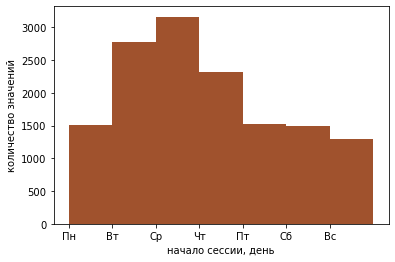

In [56]:
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
ax = train_data_10users['day_of_week'].hist(bins=np.arange(8), grid=False, color='sienna');
ax.set_xlabel('начало сессии, день');
ax.set_ylabel('количество значений');
ax.set_xticks(np.arange(7));
ax.set_xticklabels(days);

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

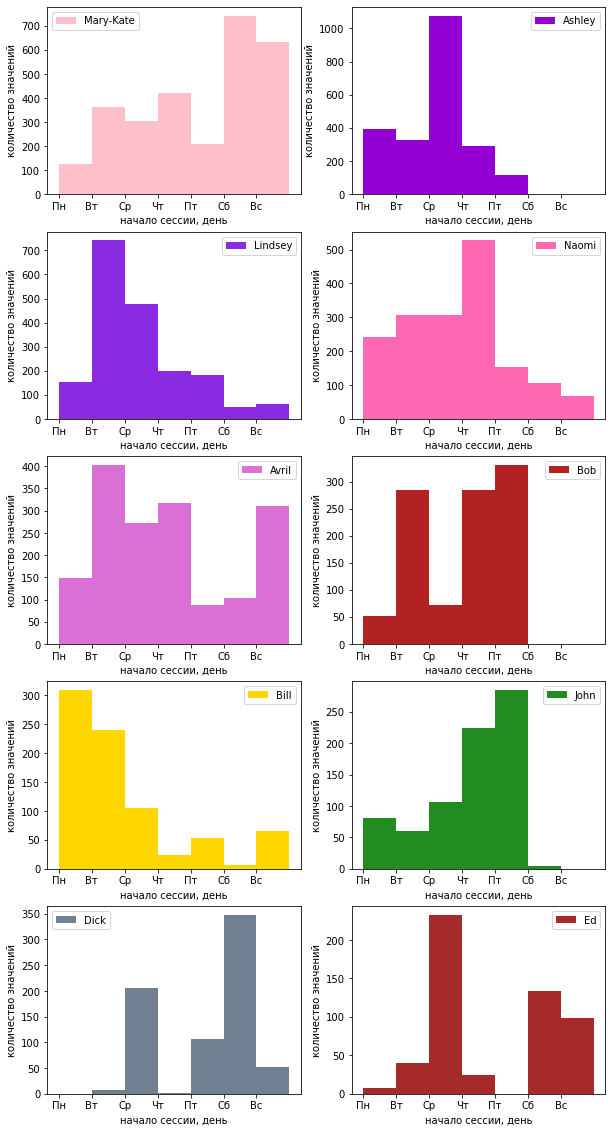

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for idx, ax in enumerate(axes.ravel()):
    data = train_data_10users[train_data_10users['target'] == usernames[idx]]['day_of_week']
    ax.hist(data, bins=np.arange(8), color=color_dic[usernames[idx]])
    ax.set_xlabel('начало сессии, день')
    ax.set_ylabel('количество значений')
    ax.legend([usernames[idx]])
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(days)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Mary-Kate** в основном посещает 2 сайта за сессию, с 9 до 11 и с 19 до 22 часов, больше всего на выходных

**Ashley** посещает 7-9 сайтов, утром и в обед, чаще всего в среду, но по выходным не заходит никуда. скорее всего она делает это по работе

**Lindsey** заходит на 6-9 сайтов, в основном в обед, больше всего во вторник

**Naomi** посещает 5-9 сайтов, тоже в обед, чаще всего по четвергам

**Avril** заходит на 5-7 сайтов, в обед и вечером, и скорее всего соблюдает шаббат

**Bob** посещает 5-9 сайтов в начале и в конце рабочего дня, только по будням. скорее всего тоже по работе

**Bill** заходит на 6-10 сайтов, в основном в обед в начале недели

**John** тоже заходит на 6-10 сайтов с 10 до 16, все чаще к концу рабочей недели. скорее всего он так прокрастинирует

**Dick** часто смотрит 2 сайта утром и вечером, больше всего в субботу

**Ed** посещает 6-9 сайтов, часто ближе к вечеру, в среду и по выходным

также, здесь женские юзернеймы пользуются интернетом в 2-3 раза активнее мужских

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [76]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as site_freq_pkl:
        site_freq10 = pickle.load(site_freq_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [89]:
top10 = list(site_freq10.items())[:10]
top10_freqs = [value[1][1] for value in top10]
top10_sites = [value[0] for value in top10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [94]:
ax = sns.barplot(x=top10_sites, y=top10_freqs);
for item in ax.get_xticklabels():
    item.set_rotation('vertical')

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [38]:
search_sites = ['google', 'yahoo', 'yandex', 'bing', 'baidu', 'duckduckgo']
video_sites = ['youtube', 'video', 'tv', 'netflix', 'hulu', 'hbo']
social_sites = ['facebook', 'instagram', 'vk', 'twitter', 'linkedin', 'message', 'msg', 'myspace']
dev_sites = ['stackoverflow', 'microsoft', 'sql', 'oracle',  'code',
        'eclipse', 'linux', 'bsd', 'w3', 'github', 'gitlab', 'java', 'python']
study_sites = ['edu', 'univ', 'library', 'wiki']
sport_sites = ['sport', 'ball', 'match', 'bid']

In [41]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as site_freq_pkl:
        site_freq = pickle.load(site_freq_pkl)
    
    MINYEAR = '2000'
    files = glob(os.path.join(path_to_csv_files, 'user*'))
    users = [pd.read_csv(file, parse_dates=['timestamp']) for file in files]
    user_ids = [int(file[-8:-4]) for file in files]
    extend_times = session_length // window_size + min(session_length % window_size, 1)
    top30 = list(site_freq.items())[:30]
    top30 = [value[0] for value in top30]
    
    def site_contains(row, tags):
        for site in row:
            if site != 0:
                for tag in tags:
                    if tag in site:
                        return 1
        return 0

    get_site_idx = lambda site: site_freq[site][0]
    get_span = lambda row: (np.max(row) - np.min(row)).astype('timedelta64[s]').astype('int')
    get_unique = lambda row: len(list(filter(lambda x: x != 0, np.unique(row))))
    get_hour = lambda row: dt.utcfromtimestamp(np.min(row).astype('datetime64[s]').astype('int')).hour
    get_day = lambda row: dt.utcfromtimestamp(np.min(row).astype('datetime64[s]').astype('int')).weekday()
    is_search = lambda row: site_contains(row, search_sites)
    is_video = lambda row: site_contains(row, video_sites)
    is_social = lambda row: site_contains(row, social_sites)
    is_dev = lambda row: site_contains(row, dev_sites)
    is_study = lambda row: site_contains(row, study_sites)
    is_sport = lambda row: site_contains(row, sport_sites)
    incl_top30 = lambda row: int(np.isin(row, top30).any())
    is_morning = lambda hour: int(hour >= 3 and hour < 12)
    is_day = lambda hour: int(hour >= 12 and hour < 18)
    is_evening = lambda hour: int(hour >= 18 and hour < 22)
    is_night = lambda hour: int(hour >= 22 or hour < 3)
    is_weekend = lambda day: int(day > 4)
    get_days = lambda row: np.min(row).astype('datetime64[D]').astype('int') - np.datetime64(MINYEAR, 'D').astype('int')
    get_hours = lambda row: np.min(row).astype('datetime64[h]').astype('int') - np.datetime64(MINYEAR, 'h').astype('int')
    get_median_span = lambda diff: np.median(diff)
    
    def get_most_freq(row):
        row = list(filter(lambda x: x != 0, row))
        unique, counts = np.unique(row, return_counts=True)
        idx = np.argmax(counts)
        return [get_site_idx(unique[idx]), counts[idx]]
    
    def user_to_session(user, user_id):
        zeros_count = (window_size - user.shape[0] % window_size) % window_size
        
        sites = user['site'].values
        sites = np.hstack([sites, np.zeros(zeros_count, dtype='int32')])
        sites = sites.reshape(-1, window_size)
        extend_sites = lambda i: np.vstack([sites[i:], np.zeros((min(i, sites.shape[0]), sites.shape[1]), dtype='int32')])
        sites = np.hstack(map(extend_sites, range(extend_times)))[:, :session_length]
        
        ts = user['timestamp'].values
        ts = np.hstack([ts, np.full(zeros_count, np.max(ts))])
        ts = ts.reshape(-1, window_size)
        extend_ts = lambda i: np.vstack([ts[i:], np.full((min(i, ts.shape[0]), ts.shape[1]), np.max(ts))])
        ts = np.hstack(map(extend_ts, range(extend_times)))[:, :session_length]
        
        diffs = np.diff(ts).astype('timedelta64[s]').astype('int')
        #spans = np.apply_along_axis(get_span, 1, ts).reshape(-1, 1)
        #uniques = np.apply_along_axis(get_unique, 1, sites).reshape(-1, 1)
        hours = np.apply_along_axis(get_hour, 1, ts).reshape(-1, 1)
        days = np.apply_along_axis(get_day, 1, ts).reshape(-1, 1)
        
        search = np.apply_along_axis(is_search, 1, sites).reshape(-1, 1)
        video = np.apply_along_axis(is_video, 1, sites).reshape(-1, 1)
        social = np.apply_along_axis(is_social, 1, sites).reshape(-1, 1)
        dev = np.apply_along_axis(is_dev, 1, sites).reshape(-1, 1)
        study = np.apply_along_axis(is_study, 1, sites).reshape(-1, 1)
        sport = np.apply_along_axis(is_sport, 1, sites).reshape(-1, 1)
        in_top30 = np.apply_along_axis(incl_top30, 1, sites).reshape(-1, 1)
        
        morning = np.apply_along_axis(is_morning, 1, hours).reshape(-1, 1)
        day = np.apply_along_axis(is_day, 1, hours).reshape(-1, 1)
        evening = np.apply_along_axis(is_evening, 1, hours).reshape(-1, 1)
        night = np.apply_along_axis(is_night, 1, hours).reshape(-1, 1)
        weekend = np.apply_along_axis(is_weekend, 1, days).reshape(-1, 1)
        
        days_2000 = np.apply_along_axis(get_days, 1, ts).reshape(-1, 1)
        hours_2000 = np.apply_along_axis(get_hours, 1, ts).reshape(-1, 1)
        median_spans = np.apply_along_axis(get_median_span, 1, diffs).reshape(-1, 1)
        most_freq = np.apply_along_axis(get_most_freq, 1, sites).reshape(-1, 2)
        
        user_id = np.full((sites.shape[0], 1), user_id)
        
        return np.hstack([search, video, social, dev, study, sport, in_top30,
                          morning, day, evening, night, weekend,
                          days_2000, hours_2000, median_spans, 
                          most_freq, user_id])
    
    sessions = np.vstack(map(user_to_session, users, user_ids))
    return pd.DataFrame(data=sessions, columns=['is_search', 'is_video', 'is_social',
                    'is_dev', 'is_study', 'is_sport', 'incl_top30', 'is_morning', 'is_day',
                    'is_evening', 'is_night', 'is_weekend', 'days_since_2000',
                    'hours_since_2000', 'median_span', 'most_freq_site', 'freq', 'target'],
                       dtype='int')

In [43]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

In [44]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

CPU times: user 1min 38s, sys: 625 ms, total: 1min 39s
Wall time: 1min 39s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [50]:
id_10users = list(new_features_10users['target'].unique())

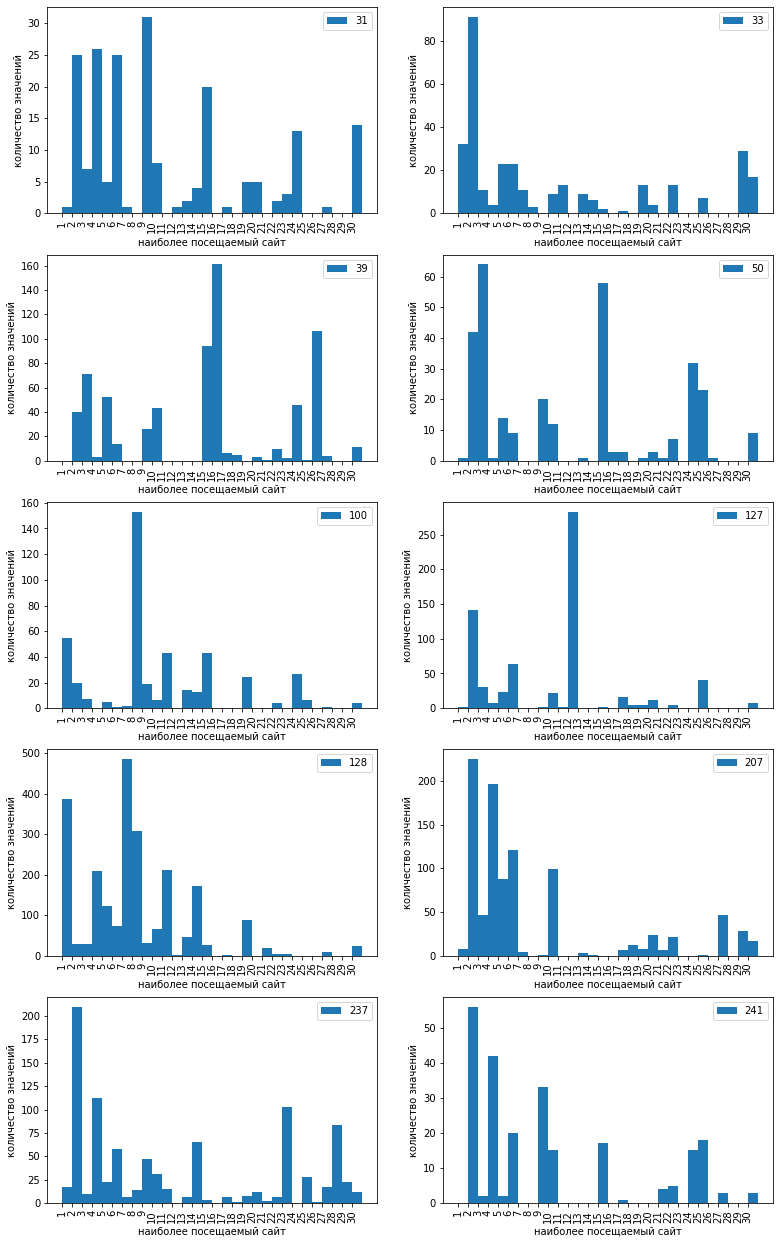

In [63]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 22))
site_count = 31

for idx, ax in enumerate(axes.ravel()):
    data = new_features_10users[new_features_10users['target'] == id_10users[idx]]['most_freq_site']
    ax.hist(data, bins=np.arange(1, site_count+1))
    ax.set_xlabel('наиболее посещаемый сайт')
    ax.set_ylabel('количество значений')
    ax.legend([id_10users[idx]])
    ax.set_xticks(np.arange(1, site_count))
    
    for item in ax.get_xticklabels():
        item.set_rotation('vertical')

In [68]:
for user in id_10users:
    print(user)
    print(new_features_10users[new_features_10users['target'] == user].describe())
    print()

31
        is_search    is_video   is_social      is_dev    is_study    is_sport  \
count  760.000000  760.000000  760.000000  760.000000  760.000000  760.000000   
mean     0.627632    0.153947    0.318421    0.086842    0.035526    0.061842   
std      0.483754    0.361136    0.466171    0.281789    0.185228    0.241027   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       incl_top30  is_morning      is_day  is_evening    is_night  is_weekend  \
count  760.000000  760.000000  760.000000  760.000000  760.000000  760.000000   
mean     0.713158    0.313158    0.675000    0.007895    0.003947    0.006579   
std      0.452585    0.4

         is_search     is_video    is_social       is_dev     is_study  \
count  1868.000000  1868.000000  1868.000000  1868.000000  1868.000000   
mean      0.839936     0.321734     0.343148     0.048180     0.055675   
std       0.366764     0.467267     0.474887     0.214203     0.229353   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          is_sport   incl_top30   is_morning       is_day   is_evening  \
count  1868.000000  1868.000000  1868.000000  1868.000000  1868.000000   
mean      0.009101     0.903640     0.212527     0.752141     0.031049   
std       0.094988     0.295163     0.409205     0.431885     0.173497   
min       0.000000     0.000000     0

In [92]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 22))
limit = 16

for idx, ax in enumerate(axes.ravel()):
    data = new_features_10users[new_features_10users['target'] == id_10users[idx]]['median_span']
    ax.hist(data, bins=np.arange(limit+1))
    ax.set_xlabel('средний интервал, с')
    ax.set_ylabel('количество значений')
    ax.legend([id_10users[idx]])
    ax.set_xticks(np.arange(limit))

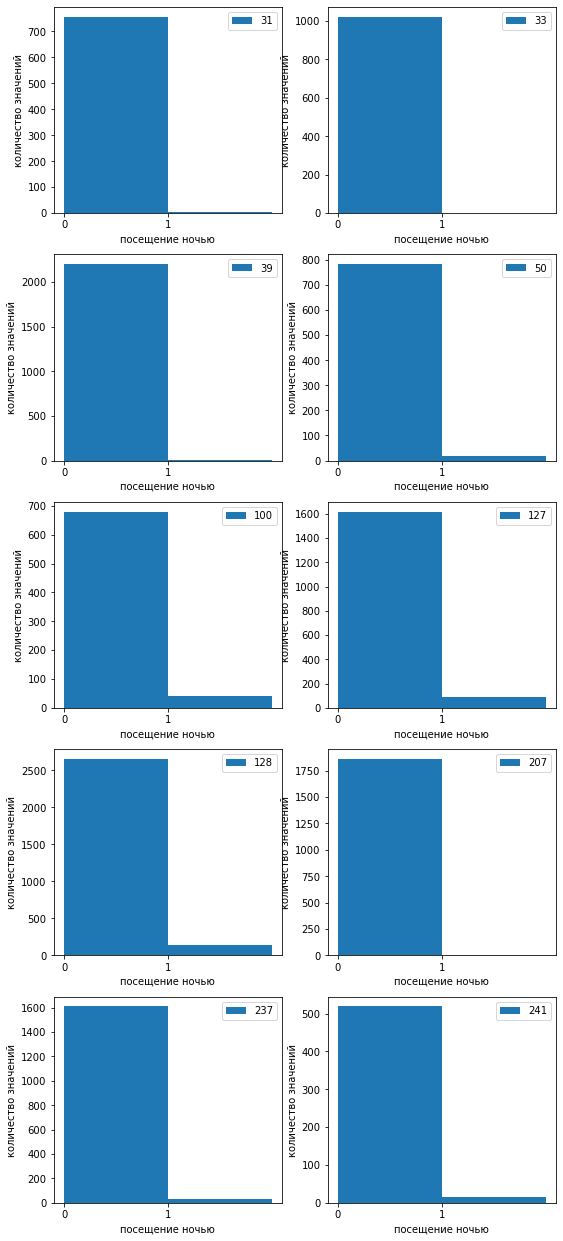

In [104]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(9, 22))

for idx, ax in enumerate(axes.ravel()):
    data = new_features_10users[new_features_10users['target'] == id_10users[idx]]['is_night']
    ax.hist(data, bins=np.arange(3))
    ax.set_xlabel('посещение ночью')
    ax.set_ylabel('количество значений')
    ax.legend([id_10users[idx]])
    ax.set_xticks(np.arange(2))
    

среди каждого признака находится уникальное значение для конкретного пользователя,
кроме ночного времени и среднего интервала

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [105]:
selected_features_10users = new_features_10users.drop(columns=['is_night', 'median_span', 'target'])
selected_features_150users = new_features_150users.drop(columns=['is_night', 'median_span', 'target'])

In [106]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 